<a href="https://colab.research.google.com/github/MS-H2020/Open/blob/main/Test9_mobilenet.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [11]:
from google.colab import drive
drive.mount('/content/drive')
!cp "/content/drive/MyDrive/Colab Notebooks/tdata.zip" .

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [12]:
temp_dir = './temp'
train_dir = temp_dir + "/tdata/train"
test_dir = temp_dir + "/tdata/test"
out_dir = '/content/drive/MyDrive/Colab Notebooks/output'
checkpoint_path = out_dir + "/cp.ckpt"

In [13]:
import shutil
import os

if os.path.isdir(temp_dir):
  shutil.rmtree(temp_dir)

In [14]:
import glob
import zipfile
shutil.unpack_archive('tdata.zip', temp_dir)
os.makedirs(test_dir+'/dummy/', exist_ok=True)
for image_path in glob.glob(test_dir + '/*'):
    shutil.move(image_path, test_dir + '/dummy')

In [15]:
import pandas as pd
df = pd.read_csv(temp_dir+"/tdata/train.csv")

rep = {5:7}
df["gender_status"] = df["gender_status"].replace(rep).astype(int)
display(df)

,image,gender_status
0,n_00001.jpg,4
1,n_00002.jpg,0
2,n_00003.jpg,0
3,n_00005.jpg,0
4,n_00006.jpg,0
...,...,...
4233,n_05293.jpg,1
4234,n_05294.jpg,1
4235,n_05295.jpg,0
4236,n_05296.jpg,0


In [16]:
from sklearn.model_selection import StratifiedKFold

N_SPLIT = 5

# Storing the average of all predictions
main_pred = []
data_kfold = pd.DataFrame()

# k-fold
kfold = StratifiedKFold(n_splits=N_SPLIT,shuffle=True,random_state=42)

In [17]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

datagen = ImageDataGenerator( rescale=1./255, # 255で割ることで正規化
                              featurewise_center = False,
                              samplewise_center = False,
                              featurewise_std_normalization = False,
                              samplewise_std_normalization = False,
                              zca_whitening = False,
                              rotation_range = 10,
                              #width_shift_range = 0.3,
                              #height_shift_range = 0.3,
                              horizontal_flip = True,
                              vertical_flip = False,
                              validation_split = 0.2
                            )

In [18]:
train_datagen = ImageDataGenerator(rescale=1./255, # 255で割ることで正規化
                                   zoom_range=0.2, # ランダムにズーム
                                   horizontal_flip = True, # 水平反転
                                   rotation_range = 20, # ランダムに回転
                                   vertical_flip = False, # 垂直反転
                                   featurewise_center=True,
                                   validation_split = 0.2
                                   )

valid_datagen = ImageDataGenerator(rescale=1./255)

In [19]:
df['gender_status'] = df['gender_status'].astype(str)
train_x = df["image"]
train_y = df["gender_status"]

import gc
from tensorflow import keras
from tensorflow.keras import datasets, layers, models, applications, optimizers
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Dense, Dropout, Flatten
from tensorflow.keras.applications import mobilenet

IMG_WIDTH = 256
IMG_HEIGHT = 256
IMG_DEPTH = 3
BATCH_SIZE = 50
CATEGORY_NUM = 7

base_model = mobilenet.MobileNet(weights='imagenet',
                  include_top=False,
                  input_shape=(IMG_HEIGHT, IMG_WIDTH, IMG_DEPTH)
                 )

base_model.trainable = False
"""
for layer in base_model.layers[-60:]:
    layer.trainable = True
"""

model = models.Sequential([
    base_model,
    layers.Flatten(),
    layers.Dense(1024, activation='relu'),
    layers.Dropout(0.1),
    layers.Dense(512, activation='relu'),
    layers.Dropout(0.2),
    layers.Dense(512, activation='relu'),
    layers.Dense(CATEGORY_NUM, activation='softmax')
])

adam_low_rate = optimizers.Adam(learning_rate=0.001)

  # モデルを構築
model.compile(optimizer=adam_low_rate,
              loss='categorical_crossentropy',
              metrics=['accuracy'])

# モデルの概要
model.summary()

# from tensorflow.keras.preprocessing.image import ImageDataGenerator
test_datagen = ImageDataGenerator(rescale=1./255)
test_generator = test_datagen.flow_from_directory(
    test_dir, target_size=(256,256), batch_size=64, class_mode=None, shuffle=False)

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 mobilenet_1.00_224 (Functi  (None, 8, 8, 1024)        3228864   
 onal)                                                           
                                                                 
 flatten_1 (Flatten)         (None, 65536)             0         
                                                                 
 dense_4 (Dense)             (None, 1024)              67109888  
                                                                 
 dropout_2 (Dropout)         (None, 1024)              0         
                                                                 
 dense_5 (Dense)             (None, 512)               524800    
                                                                 
 dropout_3 (Dropout)         (None, 512)               0         
                                                      

In [23]:
import numpy as np
# Variable for keeping count of split we are executing
j = 0
# K-fold Train and test for each split
for train_idx, val_idx in list(kfold.split(train_x,train_y)):
  '''
  if(j>0):
    # Load the previously saved weights
    latest = tf.train.latest_checkpoint(checkpoint_dir)
    model.load_weights(latest)
  '''
  x_train_df = df.iloc[train_idx]
  x_valid_df = df.iloc[val_idx]

  j+=1

  train_generator = train_datagen.flow_from_dataframe(dataframe=x_train_df,
                                                      directory=train_dir,
                                                      x_col="image",
                                                      y_col="gender_status",
                                                      class_mode='categorical',
                                                      target_size=(256,256),
                                                      batch_size=BATCH_SIZE,
                                                      shuffle=True,
                                                      subset = "training")

  val_generator = train_datagen.flow_from_dataframe(dataframe=x_valid_df,
                                                      directory=train_dir,
                                                      x_col="image",
                                                      y_col="gender_status",
                                                      class_mode='categorical',
                                                      target_size=(256,256),
                                                      batch_size=BATCH_SIZE,
                                                      shuffle=True,
                                                      subset = "validation")

  # Early stoppingを適用してフィッティング
  log = model.fit(
                  train_generator,
                  validation_data = val_generator,
                  steps_per_epoch = train_generator.samples // BATCH_SIZE,
                  validation_steps = val_generator.samples // BATCH_SIZE,
                  verbose=True,
                  #callbacks=[keras.callbacks.EarlyStopping(monitor='val_loss', min_delta=0, patience=10, verbose=1),
                  #           keras.callbacks.ModelCheckpoint(filepath=checkpoint_path, save_weights_only=True, verbose=1)],
                  callbacks=[keras.callbacks.EarlyStopping(monitor='val_loss', min_delta=0, patience=10, verbose=1)],
                  epochs = 10,
                  workers = 1
  )

  # 評価する。
  test_loss, test_acc = model.evaluate(val_generator)
  print(f"test loss: {test_loss:.2f}, test accuracy: {test_acc:.2%}")
  model.save(out_dir+'/cnn_mobile_'+str(j).zfill(2)+'.keras')
  prediction = model.predict(test_generator)
  results = np.argmax(prediction,axis=1)
  data_kfold[j] = results
  gc.collect()

Found 2712 validated image filenames belonging to 7 classes.
Found 169 validated image filenames belonging to 7 classes.


/usr/local/lib/python3.10/dist-packages/keras/src/preprocessing/image.py:1862: UserWarning: This ImageDataGenerator specifies `featurewise_center`, but it hasn't been fit on any training data. Fit it first by calling `.fit(numpy_data)`.
  warnings.warn(


Epoch 1/10
54/54 [==============================] - 60s 952ms/step - loss: 9.4394 - accuracy: 0.4722 - val_loss: 0.7715 - val_accuracy: 0.7000
Epoch 2/10
54/54 [==============================] - 51s 951ms/step - loss: 0.8813 - accuracy: 0.6935 - val_loss: 0.8022 - val_accuracy: 0.7200
Epoch 3/10
54/54 [==============================] - 50s 931ms/step - loss: 0.7265 - accuracy: 0.7498 - val_loss: 0.6822 - val_accuracy: 0.7533
Epoch 4/10
54/54 [==============================] - 50s 924ms/step - loss: 0.6505 - accuracy: 0.7727 - val_loss: 0.8089 - val_accuracy: 0.6667
Epoch 5/10
54/54 [==============================] - 51s 931ms/step - loss: 0.5589 - accuracy: 0.8073 - val_loss: 0.6572 - val_accuracy: 0.7800
Epoch 6/10
54/54 [==============================] - 53s 982ms/step - loss: 0.4892 - accuracy: 0.8291 - val_loss: 0.5494 - val_accuracy: 0.8067
Epoch 7/10
54/54 [==============================] - 51s 939ms/step - loss: 0.4980 - accuracy: 0.8321 - val_loss: 0.5901 - val_accuracy: 0.7800

/usr/local/lib/python3.10/dist-packages/keras/src/preprocessing/image.py:1862: UserWarning: This ImageDataGenerator specifies `featurewise_center`, but it hasn't been fit on any training data. Fit it first by calling `.fit(numpy_data)`.
  warnings.warn(


Epoch 1/10
54/54 [==============================] - 62s 1s/step - loss: 0.3911 - accuracy: 0.8696 - val_loss: 0.8956 - val_accuracy: 0.7133
Epoch 2/10
54/54 [==============================] - 49s 918ms/step - loss: 0.3336 - accuracy: 0.8828 - val_loss: 1.0970 - val_accuracy: 0.7333
Epoch 3/10
54/54 [==============================] - 48s 894ms/step - loss: 0.3584 - accuracy: 0.8858 - val_loss: 0.8804 - val_accuracy: 0.7000
Epoch 4/10
54/54 [==============================] - 49s 906ms/step - loss: 0.3481 - accuracy: 0.8745 - val_loss: 0.9480 - val_accuracy: 0.7067
Epoch 5/10
54/54 [==============================] - 51s 944ms/step - loss: 0.3158 - accuracy: 0.8941 - val_loss: 0.8924 - val_accuracy: 0.7533
Epoch 6/10
54/54 [==============================] - 49s 915ms/step - loss: 0.2769 - accuracy: 0.9095 - val_loss: 0.8046 - val_accuracy: 0.7400
Epoch 7/10
54/54 [==============================] - 48s 899ms/step - loss: 0.2505 - accuracy: 0.9117 - val_loss: 1.0505 - val_accuracy: 0.7800
Ep

/usr/local/lib/python3.10/dist-packages/keras/src/preprocessing/image.py:1862: UserWarning: This ImageDataGenerator specifies `featurewise_center`, but it hasn't been fit on any training data. Fit it first by calling `.fit(numpy_data)`.
  warnings.warn(


Epoch 1/10
54/54 [==============================] - 52s 964ms/step - loss: 0.2661 - accuracy: 0.9121 - val_loss: 0.3708 - val_accuracy: 0.8733
Epoch 2/10
54/54 [==============================] - 47s 869ms/step - loss: 0.2449 - accuracy: 0.9177 - val_loss: 0.3998 - val_accuracy: 0.8667
Epoch 3/10
54/54 [==============================] - 51s 952ms/step - loss: 0.2184 - accuracy: 0.9279 - val_loss: 0.5807 - val_accuracy: 0.8200
Epoch 4/10
54/54 [==============================] - 49s 909ms/step - loss: 0.2109 - accuracy: 0.9271 - val_loss: 0.5187 - val_accuracy: 0.8400
Epoch 5/10
54/54 [==============================] - 48s 884ms/step - loss: 0.1901 - accuracy: 0.9369 - val_loss: 0.5204 - val_accuracy: 0.8267
Epoch 6/10
54/54 [==============================] - 49s 907ms/step - loss: 0.1760 - accuracy: 0.9418 - val_loss: 0.5901 - val_accuracy: 0.8333
Epoch 7/10
54/54 [==============================] - 50s 923ms/step - loss: 0.1833 - accuracy: 0.9395 - val_loss: 0.5107 - val_accuracy: 0.8467

/usr/local/lib/python3.10/dist-packages/keras/src/preprocessing/image.py:1862: UserWarning: This ImageDataGenerator specifies `featurewise_center`, but it hasn't been fit on any training data. Fit it first by calling `.fit(numpy_data)`.
  warnings.warn(


Epoch 1/10
54/54 [==============================] - 51s 944ms/step - loss: 0.2074 - accuracy: 0.9324 - val_loss: 0.6345 - val_accuracy: 0.8000
Epoch 2/10
54/54 [==============================] - 49s 909ms/step - loss: 0.1522 - accuracy: 0.9489 - val_loss: 0.7149 - val_accuracy: 0.8067
Epoch 3/10
54/54 [==============================] - 50s 925ms/step - loss: 0.1393 - accuracy: 0.9538 - val_loss: 0.6966 - val_accuracy: 0.8000
Epoch 4/10
54/54 [==============================] - 49s 902ms/step - loss: 0.1313 - accuracy: 0.9501 - val_loss: 0.8109 - val_accuracy: 0.8067
Epoch 5/10
54/54 [==============================] - 46s 858ms/step - loss: 0.1566 - accuracy: 0.9425 - val_loss: 0.7910 - val_accuracy: 0.8267
Epoch 6/10
54/54 [==============================] - 51s 940ms/step - loss: 0.1144 - accuracy: 0.9617 - val_loss: 0.7070 - val_accuracy: 0.8267
Epoch 7/10
54/54 [==============================] - 46s 849ms/step - loss: 0.1034 - accuracy: 0.9621 - val_loss: 0.6676 - val_accuracy: 0.8133

/usr/local/lib/python3.10/dist-packages/keras/src/preprocessing/image.py:1862: UserWarning: This ImageDataGenerator specifies `featurewise_center`, but it hasn't been fit on any training data. Fit it first by calling `.fit(numpy_data)`.
  warnings.warn(


Epoch 1/10
54/54 [==============================] - 53s 977ms/step - loss: 0.1495 - accuracy: 0.9497 - val_loss: 1.0333 - val_accuracy: 0.7600
Epoch 2/10
54/54 [==============================] - 48s 887ms/step - loss: 0.1385 - accuracy: 0.9504 - val_loss: 0.9220 - val_accuracy: 0.8000
Epoch 3/10
54/54 [==============================] - 48s 897ms/step - loss: 0.1278 - accuracy: 0.9572 - val_loss: 0.8093 - val_accuracy: 0.7933
Epoch 4/10
54/54 [==============================] - 48s 896ms/step - loss: 0.1287 - accuracy: 0.9564 - val_loss: 0.8906 - val_accuracy: 0.7933
Epoch 5/10
54/54 [==============================] - 50s 927ms/step - loss: 0.1186 - accuracy: 0.9598 - val_loss: 0.9557 - val_accuracy: 0.7533
Epoch 6/10
54/54 [==============================] - 48s 889ms/step - loss: 0.1230 - accuracy: 0.9579 - val_loss: 1.0710 - val_accuracy: 0.7600
Epoch 7/10
54/54 [==============================] - 49s 912ms/step - loss: 0.1225 - accuracy: 0.9613 - val_loss: 0.8961 - val_accuracy: 0.7800

In [1]:
# holder
data_kfold

NameError: name 'data_kfold' is not defined

In [ ]:
'''
# testing on single iteration of HoldOut
result = data_kfold[1]
labels=(train_generator.class_indices)
labels2=dict((v,k) for k,v in labels.items())
predictions=[labels2[k] for k in result]
'''

In [50]:
ans = df.copy()

In [51]:
# Taking The Label with Maximum Occurences
labels=(test_generator.class_indices)
labels2=dict((v,k) for k,v in labels.items())
import collections
for i in range(len(data_kfold)):
    co = collections.Counter(data_kfold.loc[i])
    co = sorted(co.items(),key=lambda x: x[1],reverse=True)
    ans["gender_status"].loc[i] = labels2[co[0][0]]

KeyError: 1

In [36]:
ans

,image,gender_status
0,n_00001.jpg,4
1,n_00002.jpg,0
2,n_00003.jpg,0
3,n_00005.jpg,0
4,n_00006.jpg,0
...,...,...
4233,n_05293.jpg,1
4234,n_05294.jpg,1
4235,n_05295.jpg,0
4236,n_05296.jpg,0


In [29]:
  #print(results)
  ans.to_csv(path_or_buf=out_dir+"/out_pred.csv")

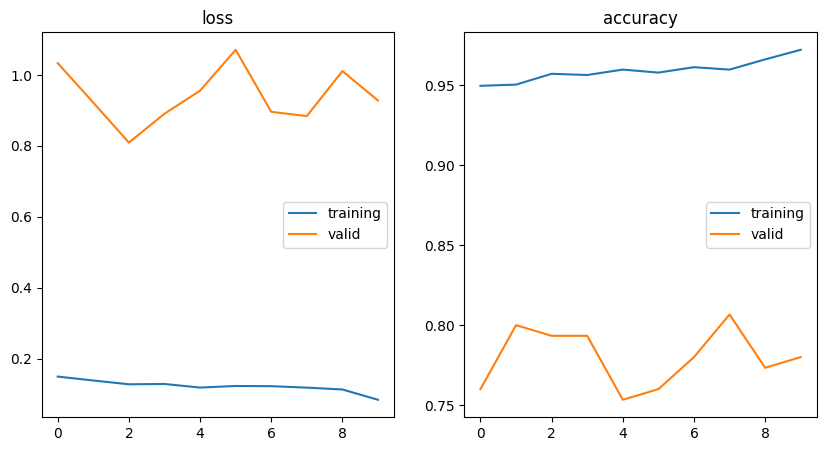

In [30]:
import matplotlib.pyplot as plt
metrics = ['loss', 'accuracy']  # 使用する評価関数を指定
plt.figure(figsize=(10, 5))  # グラフを表示するスペースを用意

for i in range(len(metrics)):

    metric = metrics[i]

    plt.subplot(1, 2, i+1)  # figureを1×2のスペースに分ける
    plt.title(metric)

    plt_train = log.history[metric]
    plt_valid  = log.history['val_' + metric]

    plt.plot(plt_train, label='training')
    plt.plot(plt_valid, label='valid')
    plt.legend()

plt.savefig("metrics.jpg")

In [31]:
#Confution Matrix and Classification Report
from sklearn.metrics import classification_report, confusion_matrix
import numpy as np

Y_pred = model.predict(val_generator, val_generator.samples // BATCH_SIZE)
y_pred = np.argmax(Y_pred, axis=1)
print('Confusion Matrix')
print(confusion_matrix(val_generator.classes, y_pred))
print('Classification Report')
print(classification_report(val_generator.classes, y_pred, target_names=None))

/usr/local/lib/python3.10/dist-packages/keras/src/preprocessing/image.py:1862: UserWarning: This ImageDataGenerator specifies `featurewise_center`, but it hasn't been fit on any training data. Fit it first by calling `.fit(numpy_data)`.
  warnings.warn(


4/4 [==============================] - 3s 597ms/step
Confusion Matrix
[[19 12  7  2  9  0  4]
 [15  6  8  4  9  0  2]
 [ 5  6  2  1  6  0  0]
 [ 4  4  2  1  3  0  1]
 [12 10  2  0  7  0  1]
 [ 0  0  0  1  0  0  0]
 [ 1  2  1  0  0  0  0]]
Classification Report
              precision    recall  f1-score   support

           0       0.34      0.36      0.35        53
           1       0.15      0.14      0.14        44
           2       0.09      0.10      0.10        20
           3       0.11      0.07      0.08        15
           4       0.21      0.22      0.21        32
           5       0.00      0.00      0.00         1
           6       0.00      0.00      0.00         4

    accuracy                           0.21       169
   macro avg       0.13      0.13      0.13       169
weighted avg       0.21      0.21      0.21       169



/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


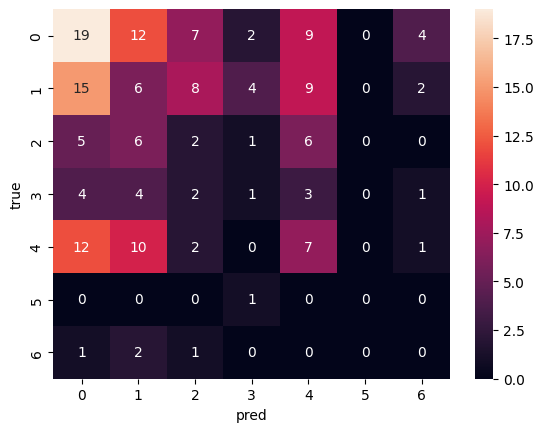

In [32]:
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns

swarm_plot = sns.heatmap(confusion_matrix(val_generator.classes, y_pred), annot=True)
plt.xlabel("pred")
plt.ylabel('true')

fig = swarm_plot.get_figure()
fig.savefig("out.png")

In [ ]:
#from tensorflow.keras.models import Model, load_model
#model = load_model('/content/drive/MyDrive/Colab Notebooks/cnn_dense121.h5')